In [1]:
from IPython.core.display import display, HTML
display(HTML('''
<style>.container { width:85% !important; }</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
'''))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams as rc
from pprint import pprint
from gdax_helpers import *
from api_key import *

In [3]:
client = gdax.AuthenticatedClient(KEY,
                                       B64SECRET,
                                       PASSPHRASE)
dfhist = get_history_df(client, get_account_df(client))
port_hist = get_portfolio_history(client, dfhist)
df = port_hist['Total']

BTC-USD Starting 2017-12-19 22:37:14.513654
found BTC-USD data
from 2017-01-01 17:00:00
to   2018-01-16 10:00:00
Filling from
2018-01-16 10:00:00
to
2018-01-16 17:00:00
storing BTC-USD in prices.h5
ETH-USD Starting 2017-12-20 00:14:53.193794
found ETH-USD data
from 2017-05-28 15:00:00
to   2018-01-16 10:00:00
Filling from
2018-01-16 10:00:00
to
2018-01-16 17:00:00
storing ETH-USD in prices.h5


In [4]:
port_hist.keys()

dict_keys(['BTC-USD', 'ETH-USD', 'USD', 'Total'])

In [5]:
rc.update({'font.size': 18})
size=(23,13)

# Holdings History

In [6]:
res = {}
for key in port_hist:
    if key != 'Total' and key != 'USD':
         res[key] = port_hist[key]['Balance']
holdings = pd.DataFrame(res)
holdings.head()

,BTC-USD,ETH-USD
time,,
2017-12-19 23:00:00,0.005663,0.000
2017-12-20 00:00:00,0.005663,0.000
2017-12-20 01:00:00,0.005663,0.125
2017-12-20 02:00:00,0.005663,0.125
2017-12-20 03:00:00,0.005663,0.125


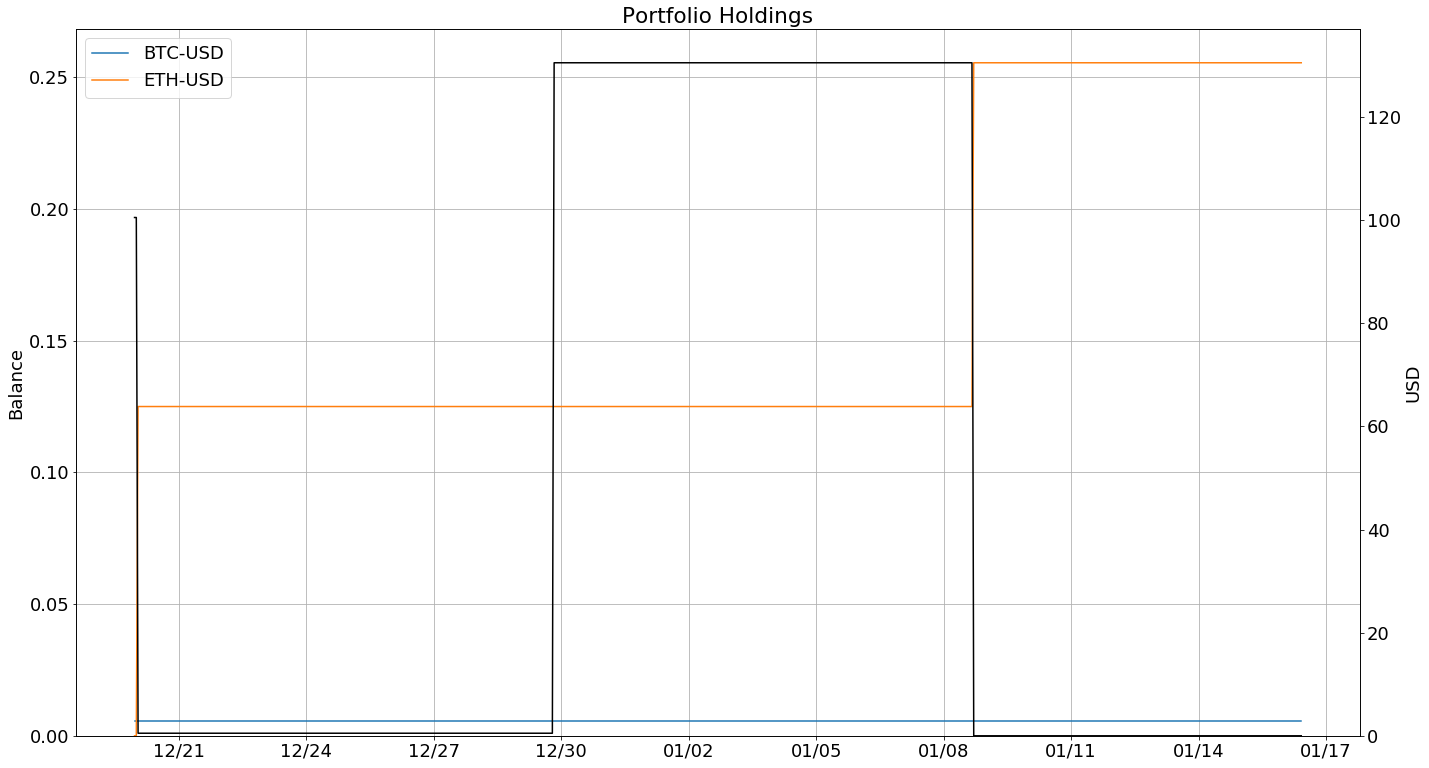

In [7]:
data = holdings
fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(data.index.to_pydatetime(), data.values)
ax.legend(data.columns)

ax.set_title('Portfolio Holdings')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Balance')

ax2 = ax.twinx()
ax2.plot(port_hist['USD']['Total'], 'k')
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.set_ylabel('USD')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# Principal Graph

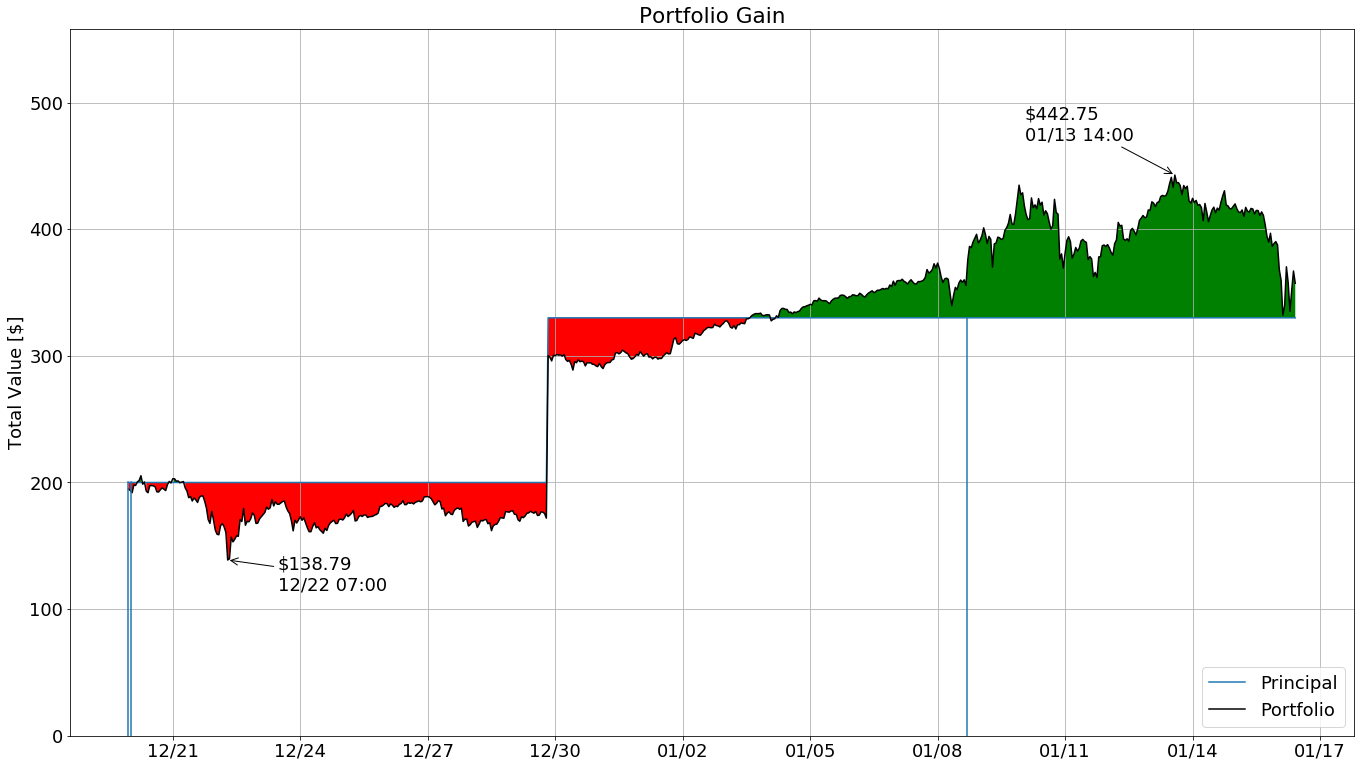

In [8]:
y1 = df['Principal']
y2 = df['Total']
x = y1.index.to_pydatetime()

fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(x, y1)
ax.plot(x, y2, 'k')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.legend(['Principal', 'Portfolio'], loc='lower right')
ax.set_title('Portfolio Gain')
ax.set_ylim(0, ax.get_ylim()[1] + 100)
ax.set_ylabel('Total Value [$]')

ax.fill_between(
    x=x,
    y1=y1.values,
    y2=y2.values,
    where=y2.values <= y1.values,
    facecolor='red'
)

ax.fill_between(
    x=x,
    y1=y1.values,
    y2=y2.values,
    where=y2.values >= y1.values,
    facecolor='green'
)

val = y2.subtract(y1, axis=0).max()
i = y2[y2.subtract(y1, axis=0) == val].index[0]
ax.annotate('${:.2f}\n{}'.format(y2.loc[i],
                                 i.strftime('%m/%d %H:%M')),
            xy=(i, y2.loc[i]),
            xycoords='data',
            xytext=(-150, 35),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

val = y2.subtract(y1, axis=0).min()
i = y2[y2.subtract(y1, axis=0) == val].index[0]
ax.annotate('${:.2f}\n{}'.format(y2.loc[i],
                                 i.strftime('%m/%d %H:%M')),
            xy=(i, y2.loc[i]),
            xycoords='data',
            xytext=(50, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

for i, row in dfhist.drop('USD', level=0).iterrows():
    x = i[1]
    y = y1[y1.index > x]
    y = y[0] / ax.get_ylim()[1]
    ax.axvline(x, ymax=y)

Text(0,0.5,'Total Value [$]')

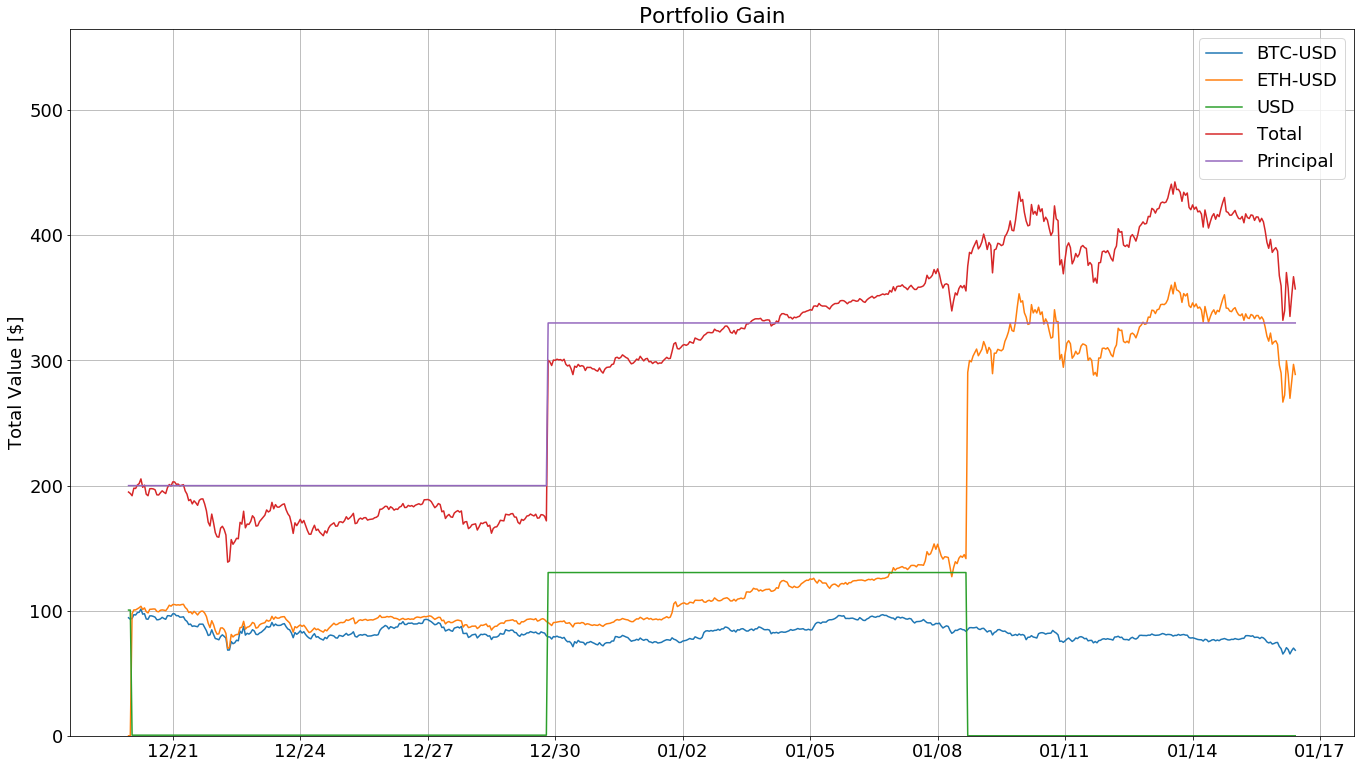

In [9]:
fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(df.index.to_pydatetime(), df.values)
ax.legend(df.columns)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('Portfolio Gain')
ax.set_ylim(0, ax.get_ylim()[1] + 100)
# ax.set_ylim(0, 22000)
ax.set_ylabel('Total Value [$]')

# Portfolio Rate

Text(50,10,'-30.61%\n12/22 07:00')

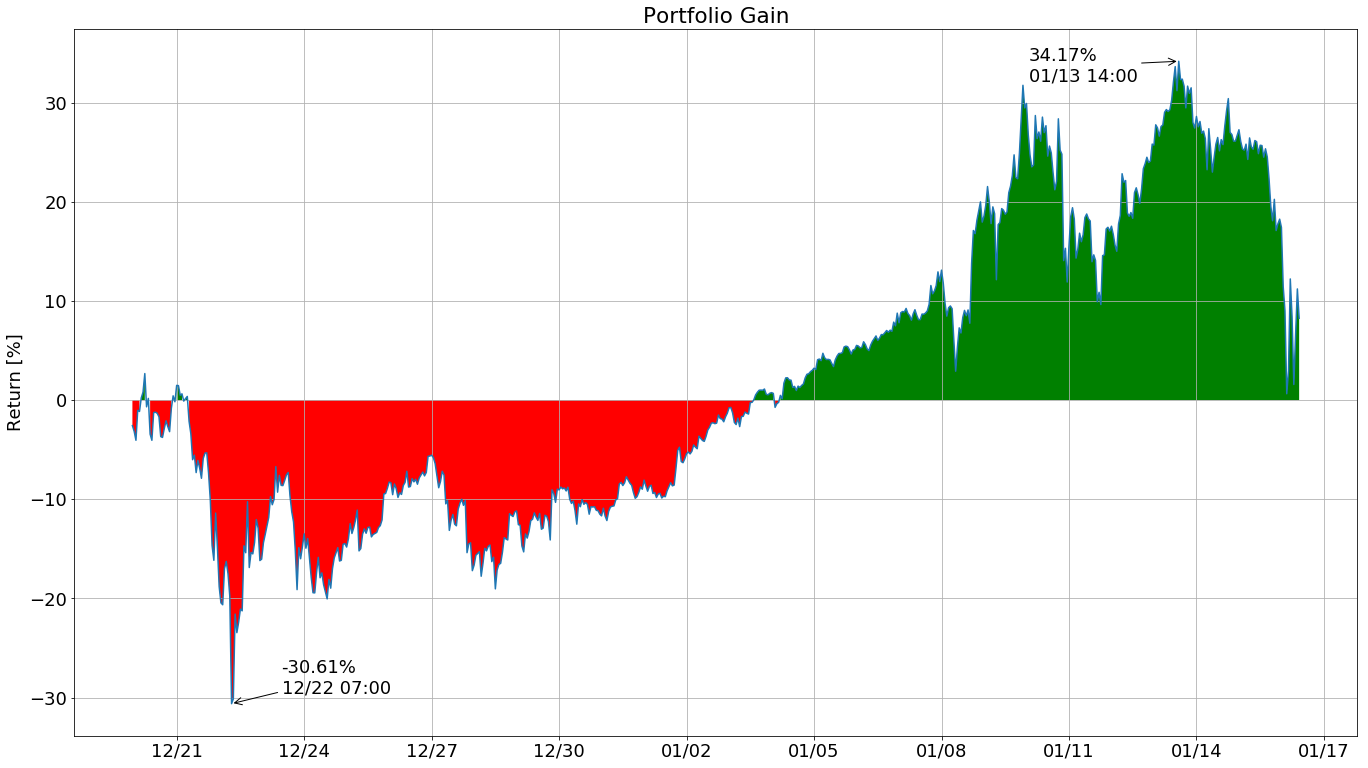

In [10]:
data = df['Total'].divide(df['Principal'], axis=0) - 1
data *= 100
fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(data.index.to_pydatetime(), data.values)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('Portfolio Gain')
ax.set_ylabel('Return [%]')

y1 = data.values
y2 = np.full((len(data.values)), 0)
ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='green'
)

ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='red'
)

ax.annotate('{:.2f}%\n{}'.format(data.max(),
                                 data[data == data.max()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.max()].index[0], data.max()),
            xycoords='data',
            xytext=(-150, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

ax.annotate('{:.2f}%\n{}'.format(data.min(),
                                 data[data == data.min()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.min()].index[0], data.min()),
            xycoords='data',
            xytext=(50, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

# Portfolio Gain

Text(50,-10,'$-61.21\n12/22 07:00')

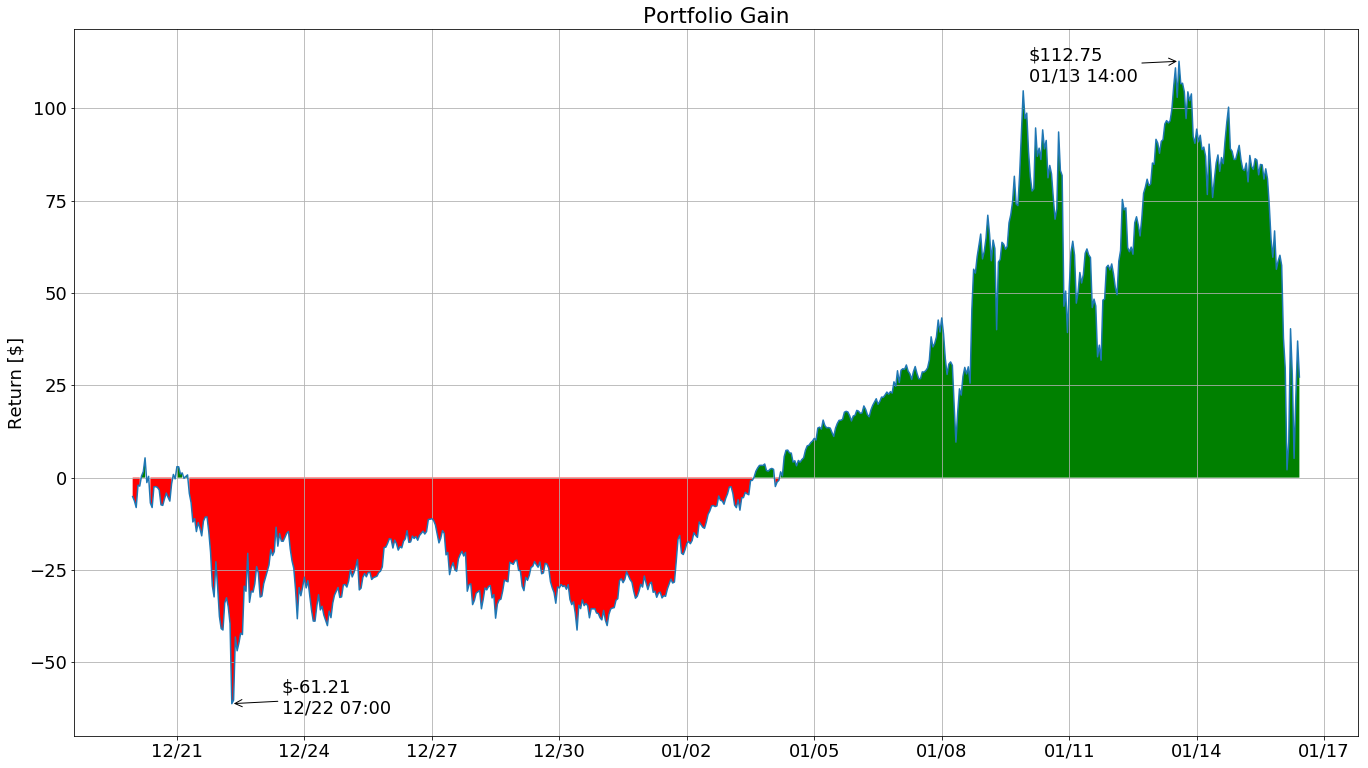

In [11]:
data = df['Total'].subtract(df['Principal'], axis=0)
fig, ax = plt.subplots(figsize=size)
ax.grid(True)
ax.plot(data.index.to_pydatetime(), data.values)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('Portfolio Gain')
# ax.set_ylim(-100, 100)
ax.set_ylabel('Return [$]')
y1 = data.values
y2 = np.full((len(data.values)), 0)
ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='green'
)

ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='red'
)


ax.annotate('${:.2f}\n{}'.format(data.max(),
                                 data[data == data.max()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.max()].index[0], data.max()),
            xycoords='data',
            xytext=(-150, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

ax.annotate('${:.2f}\n{}'.format(data.min(),
                             data[data == data.min()].index[0].strftime('%m/%d %H:%M')),
            xy=(data[data == data.min()].index[0], data.min()),
            xycoords='data',
            xytext=(50, -10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))